# TP 3: line-search approaches


In [39]:
import numpy as np
from numpy import *
import scipy.linalg
from scipy.sparse import spdiags
from scipy.sparse import identity
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import time

We remind the functions defined in TP1

In [40]:
def ndim_rosenbrock(x, a=1,b=100):
    """Compute the Rosenbrock function"""
    n=len(x)
    s=0
    for i in range(n-1):
        s=s+b*(x[i+1]-x[i]**2)**2+(a-x[i])**2
    return s


def ndim_grad_rosenbrock(x, a=1,b=100):
    """Computation  of the analytical form of the
    gradient of the Rosenbrock function"""
    n=len(x)
    g = np.zeros(n)
    g[0]= 2*(x[0]-a) -4*b*x[0]*(x[1]-x[0]**2)
    for i in range(1,n-1):
        g[i]= 2*b*(x[i]-x[i-1]**2)+2*(x[i]-a) -4*b*x[i]*(x[i+1]-x[i]**2)
    g[-1] = 2*b*(x[-1]-x[-2]**2)
    return g

def ndim_hess_rosenbrock(x, a=1,b=100):
    """Computation  of the analytical form of the
    Hessian of the Rosenbrock function"""
    n=len(x)
    h = np.zeros((n,n))
    h[0][0] = -4*b*x[1]+12*b*x[0]**2+2
    h[0][1] = -4*b*x[0]
    for i in range(1,n-1):
        h[i][i]= 2*b-4*b*x[i+1]+12*b*x[i]**2+2
        h[i][i-1]=-4*b*x[i-1]
        h[i][i+1]=-4*b*x[i]
    h[-1][-1] = 2*b
    h[-1][-2] = -4*b*x[-2]
    return h

Code the backtracking strategy. Do not recompute useless values of the gradient or of the function.

In [41]:
def backtracking(f, fx, gx, x, p, alpha0=1, b_max=30, gamma=0.1, c1=0.0001):
    """
    Backtracking line search algorithm.

    Parameters:
    f : function
        Objective function.
    fx : float
        Value of the objective function at x.
    gx : ndarray
        Gradient of the objective function at x.
    x : ndarray
        Current point.
    p : ndarray
        Search direction.
    alpha0 : float, optional
        Initial step size (default is 1).
    b_max : int, optional
        Maximum number of backtracking iterations (default is 30).
    gamma : float, optional
        Reduction factor for step size (default is 0.1).
    c1 : float, optional
        Armijo condition constant (default is 0.0001).

    Returns:
    alpha : float
        Step size.
    i : int
        Number of backtracking iterations.

    Raises:
    Exception:
        If backtracking fails after b_max iterations.
    """
    alpha = alpha0
    for i in range(b_max):
        if f(x + alpha * p) <= fx + c1 * alpha * np.dot(gx, p):
            return alpha, i
        alpha *= gamma
    raise Exception("Backtracking failed!")
          

Insert the backtracking strategy in the Newton's code. Count the number of function evaluations and produce a vector with the taken step lengths. 

In [42]:
def newton_backtrack(x,obj,grad,hess,tol,maxit):
    k=0
    g=grad(x)
    H=hess(x)
    fx=obj(x)
    fval=[fx]
    err=[linalg.norm(xT-x)/linalg.norm(xT)]
    gval=[linalg.norm(g)]
    step=[]
    ratio=[]
    countf=0 # number of function evaluations
    while k<maxit:
        k=k+1
        if np.all(np.linalg.eigvals(H) > 0):
            p=linalg.solve(H,-g)
        else: 
            raise("Not positve definite!")
        
        alpha, _ = backtracking(obj, fx, g, x, p)

        xold=x
        x=x+alpha*p
        step.append(alpha)
        ratio.append(linalg.norm(xT-x)/linalg.norm(xT-xold)**2)
        fx=obj(x)
        fval.append(fx)
        err.append(linalg.norm(xT-x)/linalg.norm(xT))
     
        g=grad(x)
        gval.append(linalg.norm(g))
        H=hess(x)
        #print(np.linalg.norm(g))
        if np.linalg.norm(g)<tol :
            print('Number of iterations for Newton method with backtrack : '+ str(k) )
            print('Number of function evaluations for Newton method with backtrack : '+ str(countf) )

            
            return x,fval,err,gval,step,ratio
    print('Maximum number of iterations reached for Newton method with backtrack ')    
    return x,fval,err,gval,step,ratio




Insert the backtracking strategy in the gradient method's code

In [43]:
def steepest_descent_backtrack(x,obj,grad,tol,maxit):
    k=0
    g=grad(x)
    err=[linalg.norm(xT-x)/linalg.norm(xT)]
    fx=obj(x)
    fval=[fx]
    gval=[linalg.norm(g)]
    step=[]
    countf=0
    alpha0=1
    xold=x
    gold=g
    while k<maxit:
        k=k+1
        
        p = -g
        alpha, _ = backtracking(obj, fx, g, x, p, alpha0=alpha0)
        
        x=x-alpha*g
        step.append(alpha)
        fx=obj(x)
        fval.append(fx)
        err.append(linalg.norm(xT-x)/linalg.norm(xT))
        g=grad(x)
        
        gval.append(linalg.norm(g))
        xold=x
        
        gold=g
        #print(np.linalg.norm(g))
        if np.linalg.norm(g)<tol :
            print('Number of iterations for gradient method with backtrack: ' + str(k))
            print('Number of function evaluations for gradient method with backtrack: ' + str(countf))
            return x,fval,err,gval,step
    print('Maximum number of iterations reached for gradient method  with backtrack')
    print('Gradient norm :'  + str(np.linalg.norm(g)))
    return x,fval,err,gval,step

Minimize the Rosenbrock function. First try the initial point x0 = [1.2, 1.2] and then the more difficult point x0 = [−1.2, 1].

a) How does the results change from the case without linesearch? Can you explain why?

b) Plot the value of the step length along the iterations, is it often reduced? Count the total number of function values and compare it to the case without linesearch.

c) Try to use the different values of $\alpha_0$ reported in the notes for the gradient descent. Observe the results

Number of iterations for Newton method with backtrack : 10
Number of function evaluations for Newton method with backtrack : 0
Number of iterations for gradient method with backtrack: 224
Number of function evaluations for gradient method with backtrack: 0


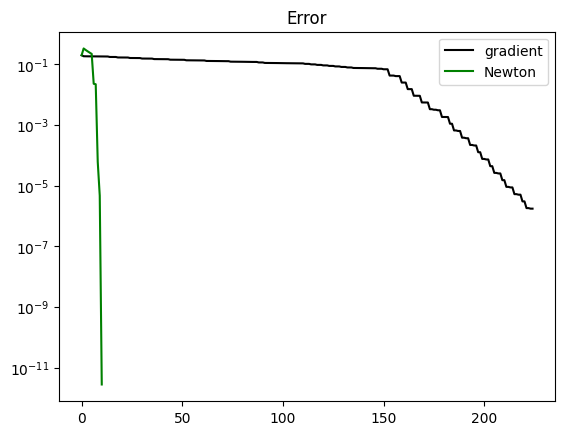

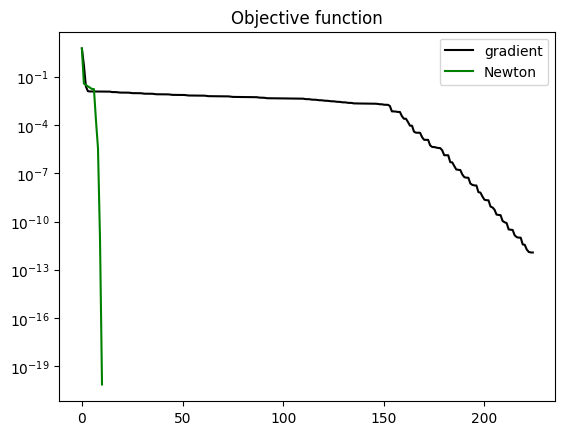

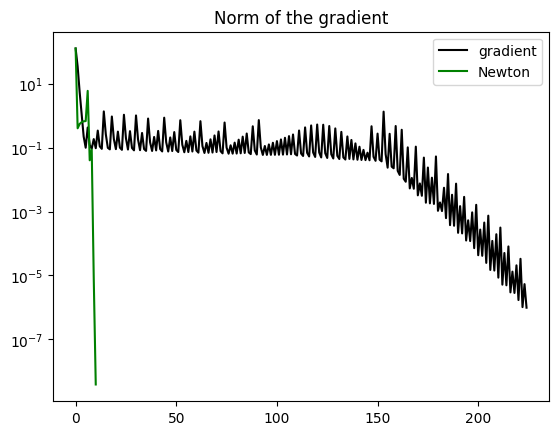

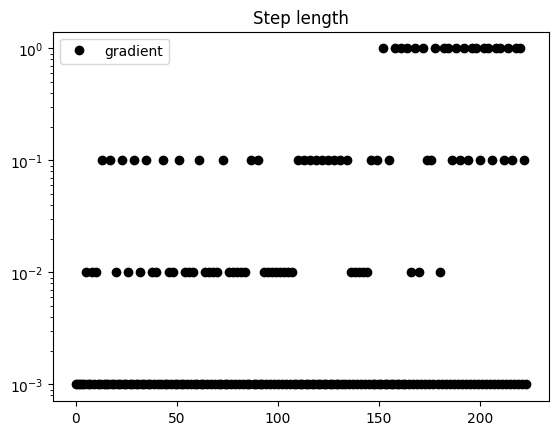

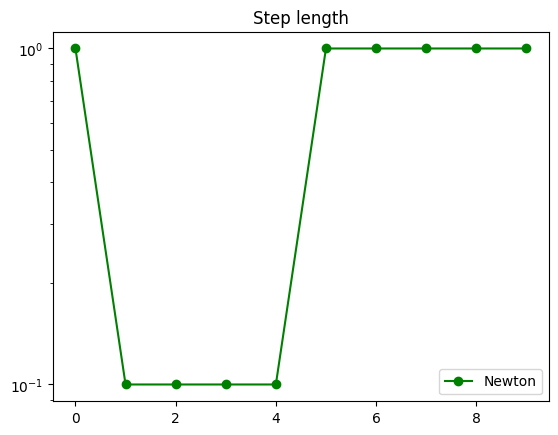

In [44]:
tol=1.e-6
maxit=1000
#x0=np.array([-1.2,1.])
x0=np.array([1.2,1.2])
xT=np.array([1.,1.])


soln,fvaln,errn,gvaln,stepn,ration=newton_backtrack(x0,ndim_rosenbrock,ndim_grad_rosenbrock,ndim_hess_rosenbrock,tol,maxit)
solg,fvalg,errg,gvalg,stepg=steepest_descent_backtrack(x0,ndim_rosenbrock,ndim_grad_rosenbrock,tol,maxit)



fig1,ax1 = plt.subplots()
ax1.semilogy(errg,'k',label='gradient')
ax1.semilogy(errn,'g',label='Newton')
ax1.set_title('Error')
legend = ax1.legend()

fig2,ax2 = plt.subplots()
ax2.semilogy(fvalg,'k',label='gradient')
ax2.semilogy(fvaln,'g',label='Newton')
ax2.set_title('Objective function')
legend = ax2.legend()

fig3,ax3 = plt.subplots()
ax3.semilogy(gvalg,'k',label='gradient')
ax3.semilogy(gvaln,'g',label='Newton')
ax3.set_title('Norm of the gradient')
legend = ax3.legend()

fig4,ax4 = plt.subplots()
ax4.semilogy(stepg,'k',label='gradient',linestyle="None",marker='o')
#ax3.semilogy(stepn,'g',label='Newton',linestyle="None")
ax4.set_title('Step length')
legend = ax4.legend()

fig4,ax4 = plt.subplots()
#ax4.semilogy(stepg,'k',label='gradient')
ax4.semilogy(stepn,'g',label='Newton',marker='o')
ax4.set_title('Step length')
legend = ax4.legend()


Try to increase the dimension 

Maximum number of iterations reached for gradient method  with backtrack
Gradient norm :0.09737408110496812


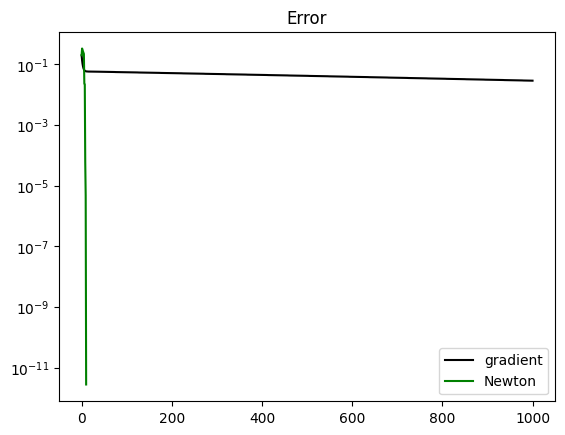

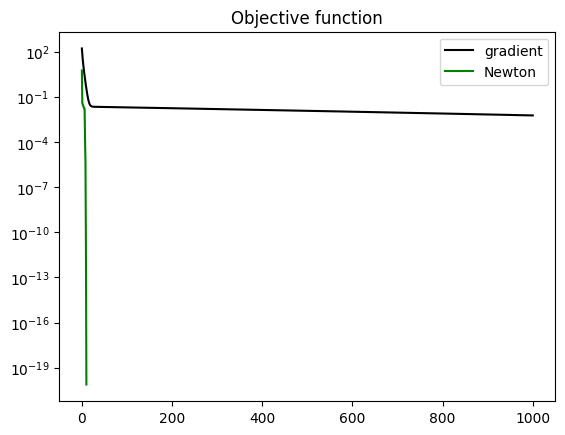

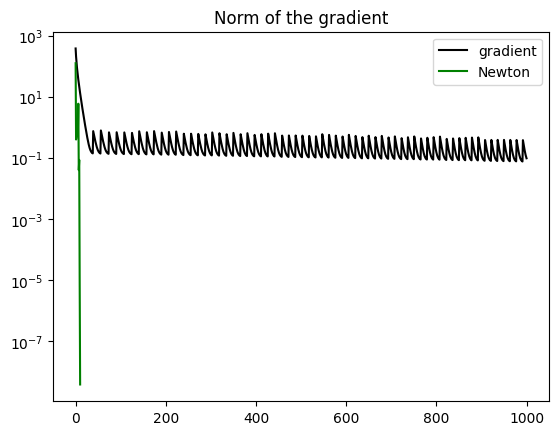

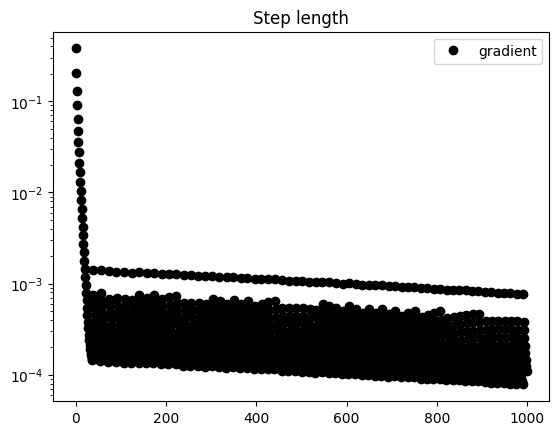

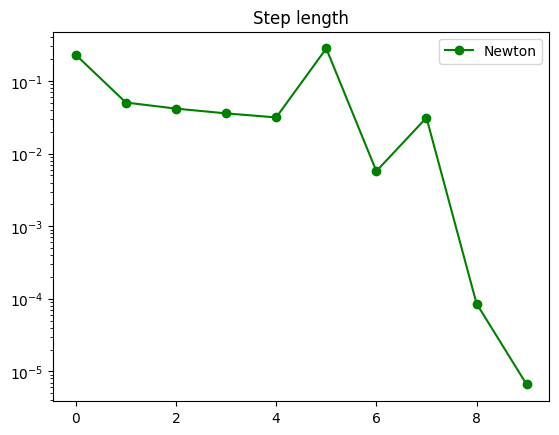

In [38]:
n=30
x0=1.2*np.ones((n,))
xT=np.ones((n,))

solg,fvalg,errg,gvalg,stepg=steepest_descent_backtrack(x0,ndim_rosenbrock,ndim_grad_rosenbrock,tol,maxit)


fig1,ax1 = plt.subplots()
ax1.semilogy(errg,'k',label='gradient')
ax1.semilogy(errn,'g',label='Newton')
ax1.set_title('Error')
legend = ax1.legend()

fig2,ax2 = plt.subplots()
ax2.semilogy(fvalg,'k',label='gradient')
ax2.semilogy(fvaln,'g',label='Newton')
ax2.set_title('Objective function')
legend = ax2.legend()

fig3,ax3 = plt.subplots()
ax3.semilogy(gvalg,'k',label='gradient')
ax3.semilogy(gvaln,'g',label='Newton')
ax3.set_title('Norm of the gradient')
legend = ax3.legend()

fig4,ax4 = plt.subplots()
ax4.semilogy(stepg,'k',label='gradient',linestyle="None",marker='o')
#ax3.semilogy(stepn,'g',label='Newton',linestyle="None")
ax4.set_title('Step length')
legend = ax4.legend()

fig4,ax4 = plt.subplots()
#ax4.semilogy(stepg,'k',label='gradient')
ax4.semilogy(stepn,'g',label='Newton',marker='o')
ax4.set_title('Step length')
legend = ax4.legend()




Study the time needed for a function evaluation depending on the dimension of the problem: line search strategies may not be feasible for very large problems

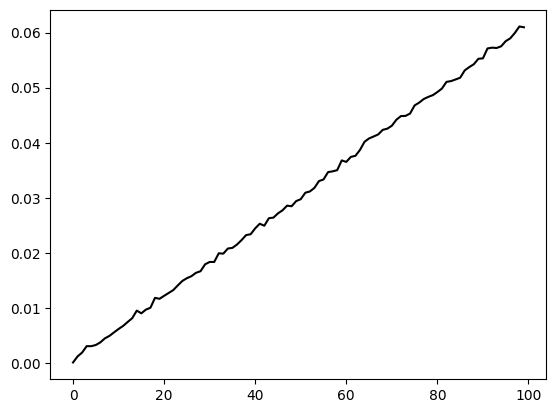

In [49]:
rr=range(100,100000,1000)
tt=len(rr)
timeg=np.zeros((tt,))
k=0
for i in rr:
  x = np.ones(i)
  start = time.time()
  ndim_rosenbrock(x)
  end = time.time()
  timeg[k] = end - start
  k += 1

fig1= plt.plot()
plt.plot(timeg,'k')


Optional: try the same study for the Rastrigin function